## Importing relevant Libraries

In [11]:
import pandas as pd
import numpy as np
import nltk, re, string
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
!pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install xgboost
import xgboost
from xgboost import XGBClassifier

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing Data

In [12]:
generic = pd.read_csv('generic_tweets.txt')
generic.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
election = pd.read_csv('Canadian_elections_2019.csv')
election.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


## Data Cleaning

First I am creating a function to perform data cleaning for the generic tweets data set. Here I am removing the weblinks, usernames, html tags, stopwords, converting the letters to small case, and stemming the words.

In [14]:
def clean_data(ind):

    result = re.sub(r"http\S+", "", generic.iloc[ind, -1]) 
    result1 = re.sub(r"@\S+", "", result)
    text = BeautifulSoup(str(result1), 'lxml').get_text()
    tokens = re.split(r'\W+', str(text))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
  
    stemmer = SnowballStemmer('english')
    stemmatized = [stemmer.stem(word) for word in words]
    
    return(stemmatized)

In [15]:
generic_clean = [str(clean_data(i)) for i in range(len(generic))]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [17]:
generic['Clean Data'] = generic_clean
generic.head()

,class,id,date,query,user,text,Clean Data
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","['awww', 'bummer', 'shoulda', 'got', 'david', ..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,"['upset', 'updat', 'facebook', 'text', 'might'..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,"['dive', 'mani', 'time', 'ball', 'manag', 'sav..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,"['whole', 'bodi', 'feel', 'itchi', 'like', 'fi..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","['behav', 'mad', 'see']"


Now I will be cleaning the data for the elections but I will be performing it in 2 parts, as for grouping the tweets based on the political party it targets I need # and @ thus i will be performing a basic cleaning in the first part. Here the weblinks, html tags and punctuations are removed. The letters are converted in small case and the newlines removed.

In [18]:
def cleandata(ind):
    result = re.sub(r"http\S+", "", election.text.iloc[ind][1:-1])
    text = BeautifulSoup(str(result), 'lxml').get_text()
    tw = text.replace('-','').replace('!','').replace('-','').replace('.','').replace("'",'').replace('"','')
    tw = tw.replace('(','').replace(')','')
    tw = tw.replace('/','')
    tw = tw.lower()
    tw = str(tw).split('\\n')
    
    return(tw)

In [19]:
clean_election = [str(cleandata(i)) for i in range(len(election))]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Data Exploration

For generic tweets I will be plotting the wordcloud for positive, negative and full data after the cleaning otherwise the frequency of the words not imparting any meaning or not relevant for sentiment analysis would be very high and they will be prominent in the wordcloud.

In [20]:
postw_ind = generic[generic['class'] == 4].index #index of positive tweets
negtw_ind = generic[generic['class'] == 0].index #index of negative tweets

In [21]:
negative_tw = [generic_clean[i] for i in negtw_ind]
positive_tw = [generic_clean[i] for i in postw_ind]

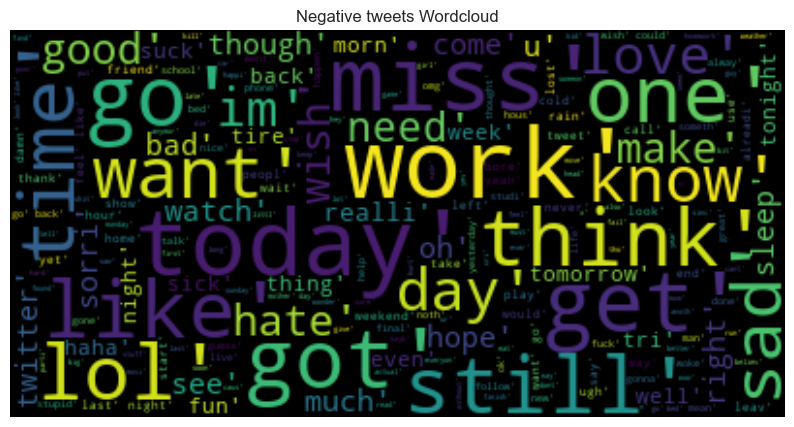

In [22]:
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(str(negative_tw))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Negative tweets Wordcloud')
plt.show()

As shown from the graph, the more the frequency of the words, bigger the number apperars in the wordcloud. The wordcloud represents negative tweets and most prominent words are work, today, miss, sad, sorry etc. which is understandable from the context of the tweets and daily life usage.

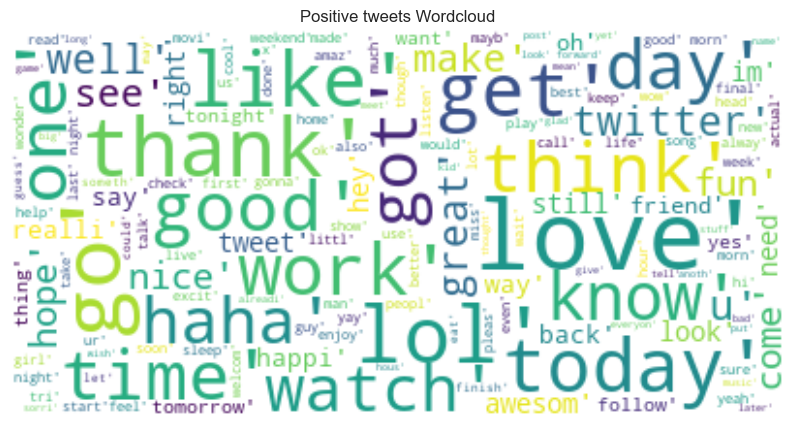

In [23]:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(str(positive_tw))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Positive tweets Wordcloud')
plt.show()

The wordcloud represents positive tweets and most prominent words are lol, love, good, thank etc. which is understandable from the context of the tweets and the daily usage of the words.

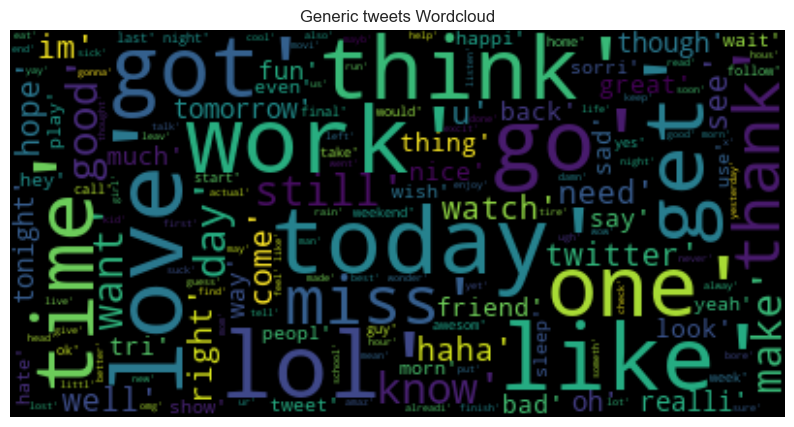

In [24]:
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(str(generic_clean))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Generic tweets Wordcloud')
plt.show()

The wordcloud represents generic tweets and most prominent words are love, like, thank, miss etc. which is a mixture of positive and negative words.

For the elections dataset, the below code will categorize the classification of the tweets for the political party. In this case only the #, @ for the party names and leaders' first name, also the acronymn of the party(eg. lpc, ndp, cpc) and leader's last name are used to categorize, if # and @ are removed then the words like conservative and liberal which are used in normal usage will wrongly categorize the tweet. If a tweet has mention of more than one political party then it is categorized as 'none' as it is difficult to categorize the tweet for a particular party.

In [25]:
party_category = []
party = ''
for i in range(len(election)):
    if (('@justin' in clean_election[i] or '@liberal' in clean_election[i] or 'lpc' in clean_election[i] or '#justin' in clean_election[i] or '#liberal' in clean_election[i] or 'trudeau' in clean_election[i])  and ('cpc' not in clean_election[i] and '#conservative' not in clean_election[i] and '@conservative' not in clean_election[i] and '@andrew' not in clean_election[i] and '#andrew' not in clean_election[i] and 'scheer' not in clean_election[i] and 'ndp' not in clean_election[i] and '@thejagmeet' not in clean_election[i] and '#thejagmeet' not in clean_election[i])):
        party = 'liberal'
    elif (('cpc' in clean_election[i] or '#conservative' in clean_election[i] or '@conservative' in clean_election[i] or '@andrew' in clean_election[i] or '#andrew' in clean_election[i] or 'scheer' in clean_election[i])  and ('@justin' not in clean_election[i] and 'lpc' not in clean_election[i] and '@liberal' not in clean_election[i] and '#justin' not in clean_election[i] and '#liberal' not in clean_election[i] and 'trudeau' not in clean_election[i] and 'ndp' not in clean_election[i] and '@thejagmeet' not in clean_election[i] and '#thejagmeet' not in clean_election[i])):
        party = 'conservative'
    elif (('ndp' in clean_election[i] or '@thejagmeet' in clean_election[i] or '#thejagmeet' in clean_election[i])  and ('cpc' not in clean_election[i] and '#conservative' not in clean_election[i] and '@conservative' not in clean_election[i] and '@andrew' not in clean_election[i] and '#andrew' not in clean_election[i] and 'scheer' not in clean_election[i] and '@justin' not in clean_election[i] and 'lpc' not in clean_election[i] and '@liberal' not in clean_election[i] and '#justin' not in clean_election[i] and '#liberal' not in clean_election[i] and 'trudeau' not in clean_election[i])):
        party = 'NDP'
    else:
        party = 'none'
    party_category.append(party)

In [26]:
election['party_category'] = party_category
election.head()

,sentiment,negative_reason,text,party_category
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",conservative
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",none
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",none
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",none
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",liberal


In [27]:
labels = ['None', 'Conservative', 'Liberal', 'NDP']

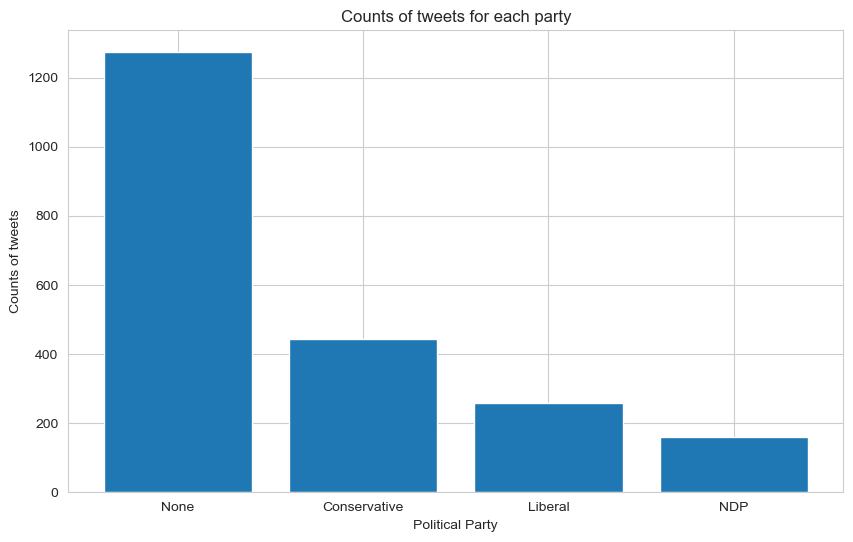

In [28]:
plt.figure(figsize=(10,6))
plt.bar(labels, election['party_category'].value_counts())
plt.xlabel('Political Party')
plt.ylabel('Counts of tweets')
plt.title('Counts of tweets for each party')
plt.show()

The plot shows the count of tweets for each political party. Here the tweets mentioning more than 1 party has been considered as none.

Now, I am interseted in knowing the count of positive and negative tweets for each party.

In [30]:
conservative_ind = election[election['party_category']=='conservative'].index

cpos = 0
cneg = 0
for i in conservative_ind:
    if election.iloc[i,0] == 'positive':
        cpos+=1
    else:
        cneg+=1

In [31]:
liberal_ind = election[election['party_category']=='liberal'].index

lpos = 0
lneg = 0
for i in liberal_ind:
    if election.iloc[i,0] == 'positive':
        lpos+=1
    else:
        lneg+=1

In [32]:
NDP_ind = election[election['party_category']=='NDP'].index

ndpos = 0
ndneg = 0
for i in NDP_ind:
    if election.iloc[i,0] == 'positive':
        ndpos+=1
    else:
        ndneg+=1

In [33]:
none_ind = election[election['party_category']=='none'].index

npos = 0
nneg = 0
for i in none_ind:
    if election.iloc[i,0] == 'positive':
        npos+=1
    else:
        nneg+=1

In [34]:
positive = (npos, cpos, lpos, ndpos)
negative = (nneg, cneg, lneg, ndneg)
positive, negative

((764, 135, 114, 114), (509, 308, 143, 46))

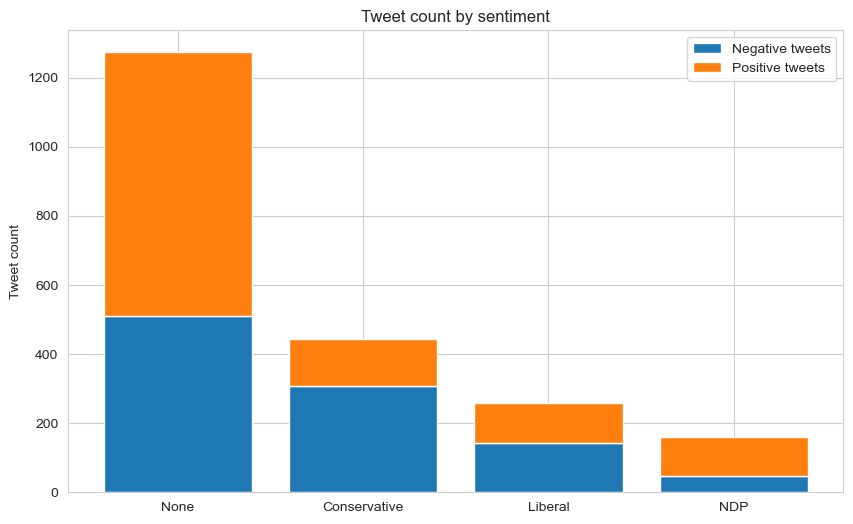

In [35]:
plt.figure(figsize=(10,6))

p1 = plt.bar(labels, negative)
p2 = plt.bar(labels, positive, bottom = negative)

plt.ylabel('Tweet count')
plt.title('Tweet count by sentiment')
plt.legend((p1[0], p2[0]), ('Negative tweets', 'Positive tweets'))

plt.show()

The plot represents the amount of positive or negative tweets for a political party. Considering from the political party point it is clear that NDP and Liberal party got good amount of positive tweets

Now, I would like to know the percentage of positive tweets with respect to total tweets for that political party.

In [36]:
perpos = []
for i in range(4):
    posper = (positive[i]/(positive[i]+negative[i]))*100
    perpos.append(posper)

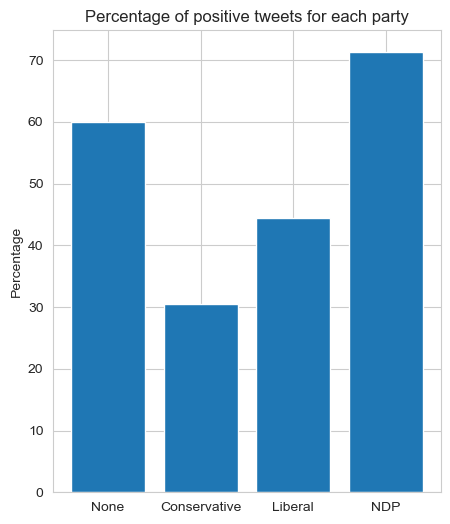

In [37]:
plt.figure(figsize=(5,6))

plt.bar(labels, perpos)

plt.ylabel('Percentage')
plt.title('Percentage of positive tweets for each party')

plt.show()

The plot represents the percentage of positive tweets for a political party, this clearly tells us that NDP got more positive tweets than negative tweets and the conservative party got almost 30% positive tweets, which means that the public is not in favour of conservative party.

### Complete cleaning of the elections dataset

First I am creating a function to perform data cleaning for the elections data set. Here I am removing the usernames, stopwords, and stemming the words.

In [38]:
def finalclean(ind):

    result1 = re.sub(r"@\S+", "", clean_election[ind])

    tokens = re.split(r'\W+', str(result1))

    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
  
    stemmer = SnowballStemmer('english')
    stemmatized = [stemmer.stem(word) for word in words]

    return(stemmatized)

In [39]:
cleanelection = [str(finalclean(i)) for i in range(len(election))]

Now, I am replacing the sentiment as positive and negative with 4 and 0 as it was the same in generic tweets.

In [40]:
election['clean data'] = cleanelection
election['sentiment_new'] = election['sentiment'].map({'negative':0, 'positive':4})
election.head()

,sentiment,negative_reason,text,party_category,clean data,sentiment_new
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",conservative,"['instead', 'suggest', 'agre', 'canadian', 'wo...",0
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",none,"['allwomanspacewalk', 'real', 'etobicokenorth'...",4
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",none,"['brantford', 'go', 'cost', 'billion', 'next',...",0
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",none,"['canada', 'canadavot', 'cant', 'decid', 'help']",4
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",liberal,"['canada', 'taxpay', 'sick', 'tire', 'hard', '...",0


In [41]:
liberal_tw = [election['clean data'][i] for i in liberal_ind]

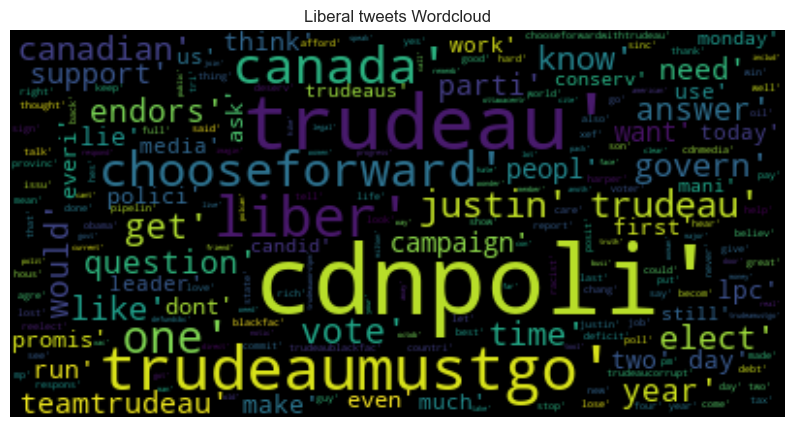

In [42]:
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(str(liberal_tw))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Liberal tweets Wordcloud')
plt.show()

From this wordcloud it seems that 'chooseforward' and the 'trudeaumustgo' have almost the same frequency thus the public is 50-50 for liberal party.

## Model preparation

Calculating the number of features after vectorization in generic tweets data and canadian election data.

In [44]:
vectorizer = CountVectorizer()
array_WF = vectorizer.fit_transform(generic_clean)
print(len(vectorizer.get_feature_names_out()))

59521


In [45]:
vectorizer_elec = CountVectorizer()
array_elec = vectorizer_elec.fit_transform(cleanelection)
print(len(vectorizer_elec.get_feature_names_out()))

5461


As the number of features are different in generic data set and elections data set thus we will encounter problem while fitting the model of generic tweets to elections. Thus, we will reduce the number of features from the generic tweets and model from that.

### Bag of words Implementation

Bag of words records the number of times a term occurs in a document.

In [65]:
vectorizer = CountVectorizer(max_features = 5000)
array_WF = vectorizer.fit_transform(generic_clean)

In [47]:
y = generic['class']
X = array_WF
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [48]:
# Implementing the Logisitc regression model
model = LogisticRegression(random_state = 0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
ACCU = accuracy_score(y_test, predictions)
print('Accuracy:', ACCU)
print(classification_report(y_test,predictions))

Accuracy: 0.76255
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     29847
           4       0.75      0.79      0.77     30153

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Implementation

As my logistic regression model coupled with bag of words gave the best performance amongst all the models, thus I would be using it to predict the results on elections data set.

In [66]:
#vectorizer_elec = CountVectorizer(max_features = 5000)
array_elec = vectorizer.transform(cleanelection)

In [67]:
predictions = model.predict(array_elec)
ACCU = accuracy_score(election['sentiment_new'], predictions)
print('Accuracy:', ACCU)
print(classification_report(y_test,predictions))

Accuracy: 0.6099390529770277


In [51]:
election['prediction'] = predictions
election.head()

,sentiment,negative_reason,text,party_category,clean data,sentiment_new,prediction
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",conservative,"['instead', 'suggest', 'agre', 'canadian', 'wo...",0,0
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",none,"['allwomanspacewalk', 'real', 'etobicokenorth'...",4,4
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",none,"['brantford', 'go', 'cost', 'billion', 'next',...",0,0
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",none,"['canada', 'canadavot', 'cant', 'decid', 'help']",4,4
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",liberal,"['canada', 'taxpay', 'sick', 'tire', 'hard', '...",0,0


I am now coding to get the number of tweets that were correctly predicted for each party.

In [52]:
ccorr = 0
cincorr = 0
for i in conservative_ind:
    if election['sentiment_new'][i] == election['prediction'][i]:
        ccorr +=1 
    else:
        cincorr +=1

In [53]:
lcorr = 0
lincorr = 0
for i in liberal_ind:
    if election['sentiment_new'][i] == election['prediction'][i]:
        lcorr +=1 
    else:
        lincorr +=1

In [55]:
ndcorr = 0
ndincorr = 0
for i in NDP_ind:
    if election['sentiment_new'][i] == election['prediction'][i]:
        ndcorr +=1 
    else:
        ndincorr +=1

In [56]:
correct = (ccorr, lcorr, ndcorr)
incorrect = (cincorr, lincorr, ndincorr)
label = ['Conservative', 'Liberal', 'NDP']

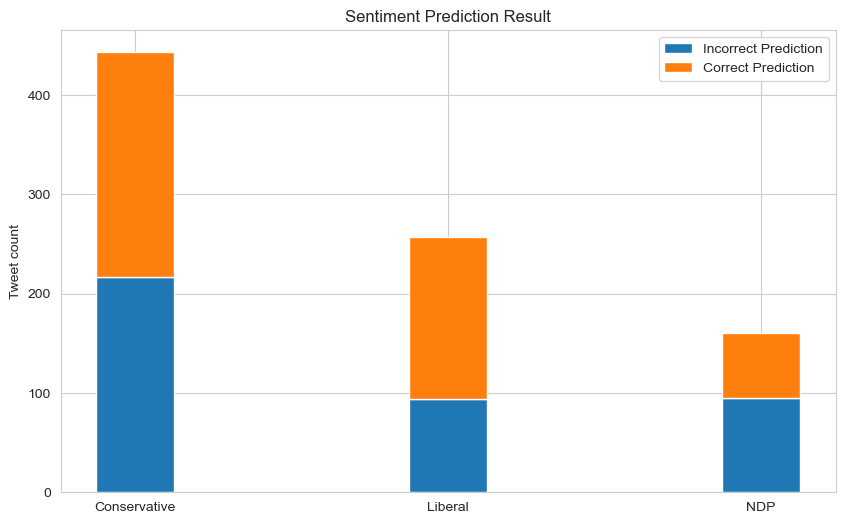

In [57]:
plt.figure(figsize=(10,6))

p1 = plt.bar(label, incorrect, width = 0.25)
p2 = plt.bar(label, correct, width = 0.25, bottom = incorrect)

plt.ylabel('Tweet count')
plt.title('Sentiment Prediction Result')
plt.legend((p1[0], p2[0]), ('Incorrect Prediction', 'Correct Prediction'))

plt.show()

The plot represents the number of tweets that were correctly classified for each party.

Now calculating the percentage of correctly classified tweets for each party.

In [68]:
percorr = []
for i in range(3):
    posper = (correct[i]/(correct[i]+incorrect[i]))*100
    percorr.append(posper)

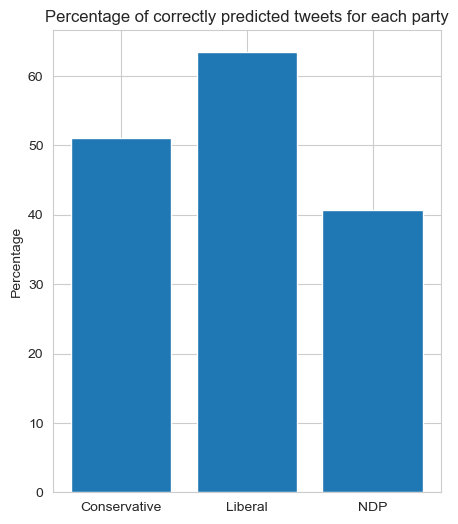

In [69]:
plt.figure(figsize=(5,6))

plt.bar(label, percorr)

plt.ylabel('Percentage')
plt.title('Percentage of correctly predicted tweets for each party')

plt.show()

According to the plot, tweets for liberal party were more correctly classified compared to the other parties.

In [70]:
election['correctly classified'] = 0
for i in election.index:
    if election['sentiment_new'][i] == election['prediction'][i]:
        election['correctly classified'][i] = 'correctly classified'
    else:
        election['correctly classified'][i] = 'incorrectly classified'

election.head()

C:\Users\User\AppData\Local\Temp\ipykernel_46820\4210292168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election['correctly classified'][i] = 'correctly classified'


,sentiment,negative_reason,text,party_category,clean data,sentiment_new,prediction,correctly classified
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",conservative,"['instead', 'suggest', 'agre', 'canadian', 'wo...",0,0,correctly classified
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",none,"['allwomanspacewalk', 'real', 'etobicokenorth'...",4,4,correctly classified
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",none,"['brantford', 'go', 'cost', 'billion', 'next',...",0,0,correctly classified
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",none,"['canada', 'canadavot', 'cant', 'decid', 'help']",4,4,correctly classified
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",liberal,"['canada', 'taxpay', 'sick', 'tire', 'hard', '...",0,0,correctly classified


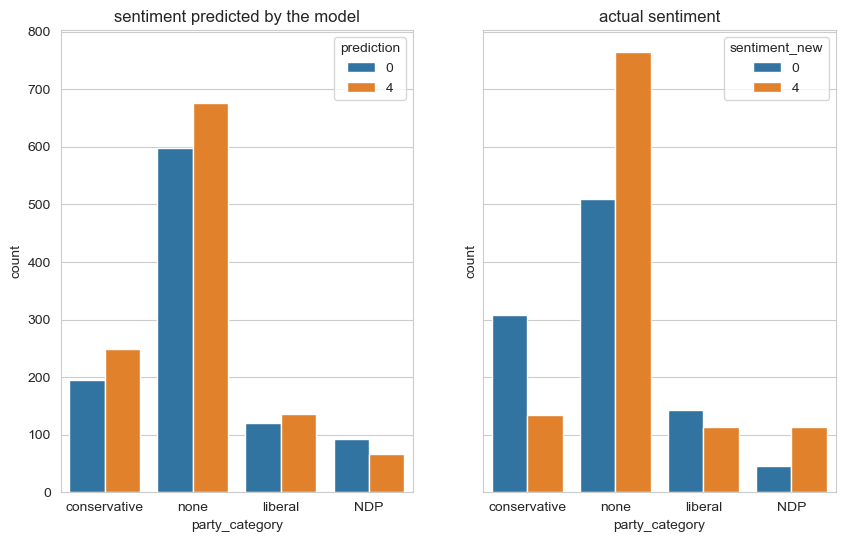

In [71]:
fig, p=plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey = True)
sns.countplot(x='party_category',data=election,hue='prediction',ax=p[0])
p[0].set_title('sentiment predicted by the model') 
sns.countplot(x='party_category',data=election,hue='sentiment_new',ax=p[1])
p[1].set_title('actual sentiment')
plt.show()

Here 0 means negative sentiment and 4 means positive sentiment.


Right now my model only has 54.48% accuracy and is not able to fully capture the sentiments because the words in the elections data set might be different than the generic tweets, thus it is not able to capture the whole scenario. The models used, work on the frequency of occurence of the words thus if some words are not considered then the model would not predict correctly. From this graph it is difficult to conclude about the NLP analytics use, but if you consider the graph of the correctly predicted data it relates much to the actual scenario of elections that happened. Thus, NLP is quite a good tool to predict the outcome of elections.

Copying the negative sentiment data set to a new dataframe

In [72]:
negdf = election[election['sentiment_new'] ==0]

In [73]:
negdf = negdf.drop('prediction', axis = 1)
negdf.head()

,sentiment,negative_reason,text,party_category,clean data,sentiment_new,correctly classified
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",conservative,"['instead', 'suggest', 'agre', 'canadian', 'wo...",0,correctly classified
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",none,"['brantford', 'go', 'cost', 'billion', 'next',...",0,correctly classified
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",liberal,"['canada', 'taxpay', 'sick', 'tire', 'hard', '...",0,correctly classified
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",conservative,"['cdnpoli', 'fact', 'blastfromthepast', 'conse...",0,correctly classified
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",none,"['chooseforward', 'cdnpoli', 'canada', 'dont',...",0,incorrectly classified


Some of the negative reasons mentioned can be clubbed together as they basically belong to the same class.

'Healthcare' and 'Healthcare and Marijuana', 'Tell lies' and 'Scandal', 'Privilege' and 'Economy' essentially address the same thing in the tweets thus these groups can be clubbed together.

In [74]:
c1 = negdf[negdf['negative_reason'] =='Healthcare'].index  
for i in c1:
    negdf.at[i,'negative_reason'] = 'Healthcare and Marijuana'
    
c2 = negdf[negdf['negative_reason'] =='Tell lies'].index  
for i in c2:
    negdf.at[i,'negative_reason'] = 'Scandal'

c3 = negdf[negdf['negative_reason'] =='Privilege'].index  
for i in c3:
    negdf.at[i,'negative_reason'] = 'Economy'

Here I am using bag of words couples with Naive Bayes, Random Forrest and SVM as models.

In [75]:
vectorizer3 = CountVectorizer()
array_WF3 = vectorizer3.fit_transform(negdf['clean data'])

In [76]:
y2 = negdf['negative_reason']
X2 = array_WF3
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0, test_size=0.3, stratify = y2)

## Results

#### Discussion for model 1

Here, I am plotting the graph for predictions made correctly for each political party with positive sentiment tweets.

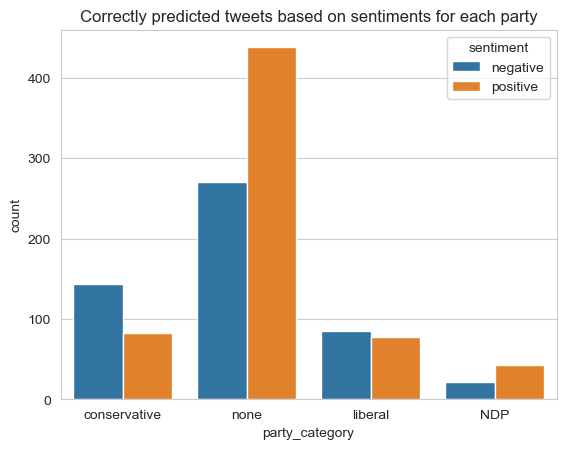

In [77]:
sns.countplot(x='party_category',data=election[election['correctly classified']=='correctly classified'],hue='sentiment')
plt.title('Correctly predicted tweets based on sentiments for each party')
plt.show()

### Hyperparameter Tuning

I wanted to perform hyperparamter tuning for logistic regression as logistic regression works best for binary classification thus i am fitting it on generic data set and i will predict it on canadian elections based on sentiments.

In [ ]:
model = LogisticRegression(random_state = 0, penalty = 'l1')
parameters = {'C':[1, 5, 10], 'solver':['liblinear', 'saga']}
gsc = GridSearchCV(model, parameters, cv=5)
gsc.fit(X_train, y_train)

In [ ]:
predictions = gsc.predict(array_elec)
ACCU = accuracy_score(election['sentiment_new'], predictions)
print('Accuracy:', ACCU)

After Hyperparameter tuning, the accuracy increased from 54.48% to 54.52%